https://github.com/huggingface/peft/blob/main/examples/fp4_finetuning/finetune_fp4_opt_bnb_peft.py

In [1]:
from torch import optim
import lightning as pl
from matplotlib import pyplot as plt

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import warnings
from peft import LoraConfig, get_peft_model, IA3Config

In [3]:
plt.style.use('ggplot')
torch.set_float32_matmul_precision('medium')
warnings.filterwarnings("ignore", ".*does not have many workers.*")

In [4]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model_name = "microsoft/phi-2"

# model = AutoModelForCausalLM.from_pretrained(
#     model_name,
#     # max_memory=max_memory,
#     quantization_config=BitsAndBytesConfig(
#         load_in_4bit=True,
#         llm_int8_threshold=6.0,
#         llm_int8_has_fp16_weight=False,
#         bnb_4bit_compute_dtype=torch.float16,
#         bnb_4bit_use_double_quant=True,
#         bnb_4bit_quant_type="nf4",
#     ),
#     torch_dtype=torch.float16,
#     trust_remote_code=True,
# )






In [5]:
# model_name = "TheBloke/phi-2-GPTQ"
model_name = "microsoft/phi-2"

def load_model():

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # quantization_config=BitsAndBytesConfig(
        #     load_in_4bit=True,
        #     llm_int8_threshold=6.0,
        #     llm_int8_has_fp16_weight=False,
        #     bnb_4bit_compute_dtype=torch.float16,
        #     bnb_4bit_use_double_quant=True,
        #     bnb_4bit_quant_type="nf4",
        # ),
        # torch_dtype=torch.float16,
        trust_remote_code=True,
    )


    # config = AutoConfig.from_pretrained(model_name, trust_remote_code=True,)
    # config.quantization_config['use_exllama'] = False
    # config.quantization_config['disable_exllama'] = True
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     torch_dtype=torch.bfloat16,
    #     trust_remote_code=True,
    #     config=config,
    # )
    return model


In [6]:
base_model = load_model()
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
from peft import TaskType

def reset_model(base_model):
    peft_config = LoraConfig(
        # task_type=TaskType.CAUSAL_LM, 
        target_modules=[
            #  "fc1", 
             "fc2",
                 "out_proj",
                   "Wqkv",],
        inference_mode=False, r=16, lora_alpha=8, 
        lora_dropout=0.1, 
        # bias="all"
    )
    # peft_config = IA3Config(
    #     target_modules=[ "fc2",  "Wqkv",], 
    #         feedforward_modules=["fc2"],
    #         inference_mode=False,
    # )
    model = get_peft_model(base_model, peft_config)
    model.config.use_cache = False
    return model

model = reset_model(base_model)

In [8]:
import json
MAX_LEN = 2000
samples = json.load(open("../samples.json"))


## Helpers

In [9]:
# modified from https://github.dev/huggingface/evaluate/blob/8dfe05784099fb9af55b8e77793205a3b7c86465/measurements/perplexity/perplexity.py#L154

# from evaluate.measurements.perplexity import Perplexity
import evaluate
from evaluate import logging
from torch.nn import CrossEntropyLoss

# @evaluate.utils.file_utils.add_start_docstrings(_DESCRIPTION, _KWARGS_DESCRIPTION)
def perplexity_compute(
    data, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
):

    if device is not None:
        assert device in ["gpu", "cpu", "cuda"], "device should be either gpu or cpu."
        if device == "gpu":
            device = "cuda"
    else:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # model = AutoModelForCausalLM.from_pretrained(model_id)
    model = model.to(device)

    # tokenizer = AutoTokenizer.from_pretrained(model_id)

    # # if batch_size > 1 (which generally leads to padding being required), and
    # # if there is not an already assigned pad_token, assign an existing
    # # special token to also be the padding token
    # if tokenizer.pad_token is None and batch_size > 1:
    #     existing_special_tokens = list(tokenizer.special_tokens_map_extended.values())
    #     # check that the model already has at least one special token defined
    #     assert (
    #         len(existing_special_tokens) > 0
    #     ), "If batch_size > 1, model must have at least one special token to use for padding. Please use a different model or set batch_size=1."
    #     # assign one of the special tokens to also be the pad token
    #     tokenizer.add_special_tokens({"pad_token": existing_special_tokens[0]})

    # if add_start_token and max_length:
    #     # leave room for <BOS> token to be added:
    #     assert (
    #         tokenizer.bos_token is not None
    #     ), "Input model must already have a BOS token if using add_start_token=True. Please use a different model, or set add_start_token=False"
    #     max_tokenized_len = max_length - 1
    # else:
    max_tokenized_len = max_length

    encodings = tokenizer(
        data,
        add_special_tokens=False,
        padding=True,
        truncation=True if max_tokenized_len else False,
        max_length=max_tokenized_len,
        return_tensors="pt",
        return_attention_mask=True,
    ).to(device)

    encoded_texts = encodings["input_ids"]
    attn_masks = encodings["attention_mask"]

    # check that each input is long enough:
    if add_start_token:
        assert torch.all(torch.ge(attn_masks.sum(1), 1)), "Each input text must be at least one token long."
    else:
        assert torch.all(
            torch.ge(attn_masks.sum(1), 2)
        ), "When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings."

    ppls = []
    loss_fct = CrossEntropyLoss(reduction="none")

    for start_index in logging.tqdm(range(0, len(encoded_texts), batch_size)):
        end_index = min(start_index + batch_size, len(encoded_texts))
        encoded_batch = encoded_texts[start_index:end_index]
        attn_mask = attn_masks[start_index:end_index]

        # if add_start_token:
        #     bos_tokens_tensor = torch.tensor([[tokenizer.bos_token_id]] * encoded_batch.size(dim=0)).to(device)
        #     encoded_batch = torch.cat([bos_tokens_tensor, encoded_batch], dim=1)
        #     attn_mask = torch.cat(
        #         [torch.ones(bos_tokens_tensor.size(), dtype=torch.int64).to(device), attn_mask], dim=1
        #     )

        labels = encoded_batch

        with torch.no_grad():
            out_logits = model(encoded_batch, attention_mask=attn_mask).logits
            # print(out_logits.shape)

        shift_logits = out_logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

        perplexity_batch = torch.exp(
            (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
            / shift_attention_mask_batch.sum(1)
        )
        # perplexity_batch = torch.exp(
        #     (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch)
        #     / shift_attention_mask_batch.sum(1)
        # )
        # print(perplexity_batch.shape)

        ppls += perplexity_batch.tolist()

    return {"perplexities": ppls, "mean_perplexity": torch.tensor(ppls).mean()}

In [10]:
# perplexity_compute(
#     second_half, model, tokenizer
# )

## Training

In [11]:
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

## Lightning helpers

In [12]:
def eval(model, tokenizer, second_half):
    model.eval();
    with torch.no_grad():
        with model.disable_adapter():
            results = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
        results2 = perplexity_compute(data=second_half, model=model, tokenizer=tokenizer, device='cuda')
    return dict(before=results['mean_perplexity'].item(), after=results2['mean_perplexity'].item())


# Train

In [13]:
from datasets import Dataset


def compute_metrics(eval_prediction):
    return {}

Trainer docs

- https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer

In [14]:
def learn_sample(sample):
    # device = 'cuda'
    # lr = 4e-3
    # epochs = 3
    # accum_steps = 1
    batch_size = 1
    verbose = True

    s = sample['text']
    first_half = s[:len(s)//2]
    second_half = s[len(s)//2:]
    ds_train = Dataset.from_dict(tokenizer([first_half]))
    ds_val = Dataset.from_dict(tokenizer([second_half]))

    os.environ['CUDA_VISIBLE_DEVICES']="1"
    model = reset_model(base_model)
    eval(model, tokenizer, second_half)

    # https://huggingface.co/docs/transformers/v4.36.1/en/main_classes/trainer#transformers.Trainer
    trainer = transformers.Trainer(
        model=model,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        compute_metrics=compute_metrics, # without this it wont even give val loss
        args=transformers.TrainingArguments(
            # checkpoint='epoch',
            save_strategy='epoch',
            label_names=['labels',],
            per_device_train_batch_size=batch_size,
            # gradient_accumulation_steps=1,
            warmup_steps=4,
            max_steps=10,
            learning_rate=1e-5,
            fp16=True,
            logging_steps=1,
            output_dir="outputs",
            log_level='error',
            # do_eval=True,
            evaluation_strategy="epoch",
            eval_steps=1,
            load_best_model_at_end=True,
            
            # disable_tqdm=not verbose,
        ),
        data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    )
    trainer._signature_columns = ['input_ids', 'attention_mask', 'labels',]
    model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
    train_output = trainer.train()

    df_hist = pd.DataFrame(trainer.state.log_history)
    df_hist_epoch = df_hist.groupby('epoch').last().drop(columns=['step'])
    df_hist_step = df_hist.set_index('step').dropna(thresh=2, axis=1)
    if verbose:
        df_hist_epoch['loss'].plot()
        plt.twinx()
        df_hist_epoch['eval_loss'].plot(c='b', label='eval')
        plt.legend()
        plt.show()


    result_train = {f'train/{k}':v for k,v in eval(model, tokenizer, first_half).items()}
    result = eval(model, tokenizer, second_half)
    result['hist'] = df_hist_epoch
    result.update(result_train)
    return result


100%|██████████| 1/1 [00:00<00:00,  8.53it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
  0%|          | 0/10 [00:00<?, ?it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 10%|█         | 1/10 [00:00<00:04,  2.05it/s]

{'loss': 2.8691, 'learning_rate': 2.5e-06, 'epoch': 1.0}


                                              
 10%|█         | 1/10 [00:00<00:04,  2.05it/s]

{'eval_loss': 2.6309354305267334, 'eval_runtime': 0.1222, 'eval_samples_per_second': 8.183, 'eval_steps_per_second': 8.183, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 20%|██        | 2/10 [00:01<00:06,  1.25it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8877, 'learning_rate': 5e-06, 'epoch': 2.0}


                                              
 20%|██        | 2/10 [00:01<00:06,  1.25it/s]

{'eval_loss': 2.63094162940979, 'eval_runtime': 0.1228, 'eval_samples_per_second': 8.141, 'eval_steps_per_second': 8.141, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 30%|███       | 3/10 [00:02<00:06,  1.08it/s]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8805, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}


                                              
 30%|███       | 3/10 [00:02<00:06,  1.08it/s]

{'eval_loss': 2.6306440830230713, 'eval_runtime': 0.1224, 'eval_samples_per_second': 8.173, 'eval_steps_per_second': 8.173, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 40%|████      | 4/10 [00:04<00:06,  1.16s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8866, 'learning_rate': 1e-05, 'epoch': 4.0}


                                              
 40%|████      | 4/10 [00:04<00:06,  1.16s/it]

{'eval_loss': 2.630582332611084, 'eval_runtime': 0.1242, 'eval_samples_per_second': 8.054, 'eval_steps_per_second': 8.054, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 50%|█████     | 5/10 [00:05<00:06,  1.24s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8515, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}


                                              
 50%|█████     | 5/10 [00:05<00:06,  1.24s/it]

{'eval_loss': 2.6303563117980957, 'eval_runtime': 0.1212, 'eval_samples_per_second': 8.251, 'eval_steps_per_second': 8.251, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 60%|██████    | 6/10 [00:06<00:04,  1.21s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.9069, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}


                                              
 60%|██████    | 6/10 [00:06<00:04,  1.21s/it]

{'eval_loss': 2.6301307678222656, 'eval_runtime': 0.1234, 'eval_samples_per_second': 8.103, 'eval_steps_per_second': 8.103, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 70%|███████   | 7/10 [00:07<00:03,  1.16s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.865, 'learning_rate': 5e-06, 'epoch': 7.0}


                                              
 70%|███████   | 7/10 [00:07<00:03,  1.16s/it]

{'eval_loss': 2.630467414855957, 'eval_runtime': 0.1221, 'eval_samples_per_second': 8.187, 'eval_steps_per_second': 8.187, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 80%|████████  | 8/10 [00:09<00:02,  1.23s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8585, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}


                                              
 80%|████████  | 8/10 [00:09<00:02,  1.23s/it]

{'eval_loss': 2.631161689758301, 'eval_runtime': 0.1216, 'eval_samples_per_second': 8.226, 'eval_steps_per_second': 8.226, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
 90%|█████████ | 9/10 [00:10<00:01,  1.34s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8692, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}


                                              
 90%|█████████ | 9/10 [00:10<00:01,  1.34s/it]

{'eval_loss': 2.6314282417297363, 'eval_runtime': 0.1207, 'eval_samples_per_second': 8.284, 'eval_steps_per_second': 8.284, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|██████████| 10/10 [00:12<00:00,  1.59s/it]/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8836, 'learning_rate': 0.0, 'epoch': 10.0}


                                               
100%|██████████| 10/10 [00:12<00:00,  1.59s/it]

{'eval_loss': 2.631455659866333, 'eval_runtime': 0.1191, 'eval_samples_per_second': 8.394, 'eval_steps_per_second': 8.394, 'epoch': 10.0}


100%|██████████| 10/10 [00:13<00:00,  1.39s/it]

{'train_runtime': 13.8894, 'train_samples_per_second': 1.44, 'train_steps_per_second': 0.72, 'train_loss': 2.8758553981781008, 'epoch': 10.0}


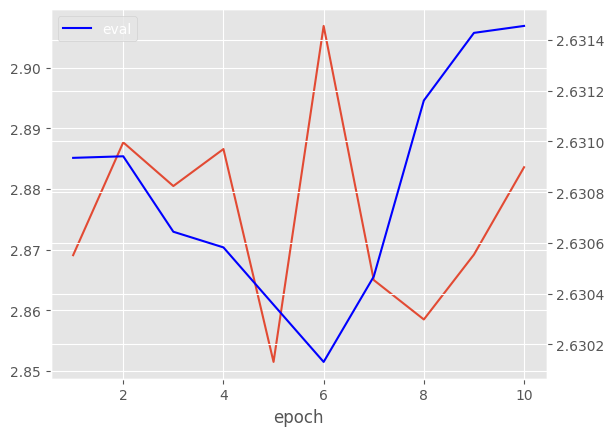

100%|██████████| 1/1 [00:00<00:00,  8.46it/s]


bad_ml
{'before': 13.885271072387695, 'after': 13.874102592468262}


100%|██████████| 1/1 [00:00<00:00, 11.90it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.375, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 3.3444020748138428, 'eval_runtime': 0.0748, 'eval_samples_per_second': 13.369, 'eval_steps_per_second': 13.369, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.3792, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 3.3444230556488037, 'eval_runtime': 0.0721, 'eval_samples_per_second': 13.861, 'eval_steps_per_second': 13.861, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4435, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 3.3442118167877197, 'eval_runtime': 0.0704, 'eval_samples_per_second': 14.202, 'eval_steps_per_second': 14.202, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.3473, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 3.3446550369262695, 'eval_runtime': 0.0716, 'eval_samples_per_second': 13.959, 'eval_steps_per_second': 13.959, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.3052, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 3.3441321849823, 'eval_runtime': 0.0711, 'eval_samples_per_second': 14.068, 'eval_steps_per_second': 14.068, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4044, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 3.3439669609069824, 'eval_runtime': 0.0705, 'eval_samples_per_second': 14.176, 'eval_steps_per_second': 14.176, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.3996, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 3.344259262084961, 'eval_runtime': 0.0786, 'eval_samples_per_second': 12.715, 'eval_steps_per_second': 12.715, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4594, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 3.343461751937866, 'eval_runtime': 0.0714, 'eval_samples_per_second': 14.002, 'eval_steps_per_second': 14.002, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.3788, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 3.344158172607422, 'eval_runtime': 0.0711, 'eval_samples_per_second': 14.073, 'eval_steps_per_second': 14.073, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4302, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 3.343691825866699, 'eval_runtime': 0.0722, 'eval_samples_per_second': 13.859, 'eval_steps_per_second': 13.859, 'epoch': 10.0}
{'train_runtime': 15.52, 'train_samples_per_second': 1.289, 'train_steps_per_second': 0.644, 'train_loss': 3.3922712326049806, 'epoch': 10.0}


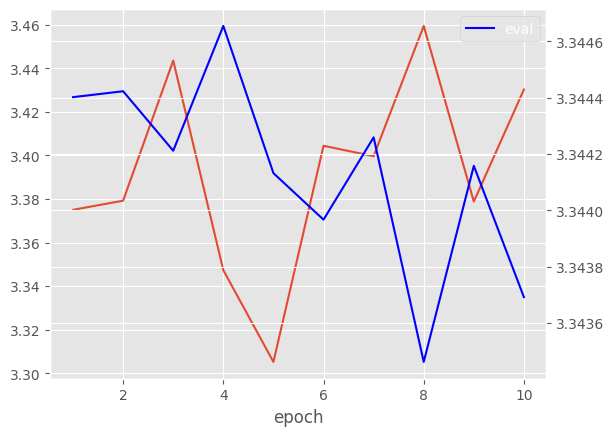

100%|██████████| 1/1 [00:00<00:00, 12.06it/s]


good_ml
{'before': 28.339096069335938, 'after': 28.31243324279785}


100%|██████████| 1/1 [00:00<00:00,  8.24it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.6742, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 2.772010564804077, 'eval_runtime': 0.1278, 'eval_samples_per_second': 7.822, 'eval_steps_per_second': 7.822, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6839, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 2.7720797061920166, 'eval_runtime': 0.1266, 'eval_samples_per_second': 7.898, 'eval_steps_per_second': 7.898, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.667, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 2.771838426589966, 'eval_runtime': 0.1273, 'eval_samples_per_second': 7.854, 'eval_steps_per_second': 7.854, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6788, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 2.771756410598755, 'eval_runtime': 0.1333, 'eval_samples_per_second': 7.503, 'eval_steps_per_second': 7.503, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6894, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 2.7716634273529053, 'eval_runtime': 0.1304, 'eval_samples_per_second': 7.666, 'eval_steps_per_second': 7.666, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6981, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 2.7719693183898926, 'eval_runtime': 0.1269, 'eval_samples_per_second': 7.88, 'eval_steps_per_second': 7.88, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6772, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 2.772239923477173, 'eval_runtime': 0.1286, 'eval_samples_per_second': 7.776, 'eval_steps_per_second': 7.776, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6648, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 2.771648645401001, 'eval_runtime': 0.1289, 'eval_samples_per_second': 7.755, 'eval_steps_per_second': 7.755, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.689, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 2.7726099491119385, 'eval_runtime': 0.1288, 'eval_samples_per_second': 7.764, 'eval_steps_per_second': 7.764, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.6739, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 2.7720842361450195, 'eval_runtime': 0.1292, 'eval_samples_per_second': 7.743, 'eval_steps_per_second': 7.743, 'epoch': 10.0}
{'train_runtime': 12.8731, 'train_samples_per_second': 1.554, 'train_steps_per_second': 0.777, 'train_loss': 2.679630756378174, 'epoch': 10.0}


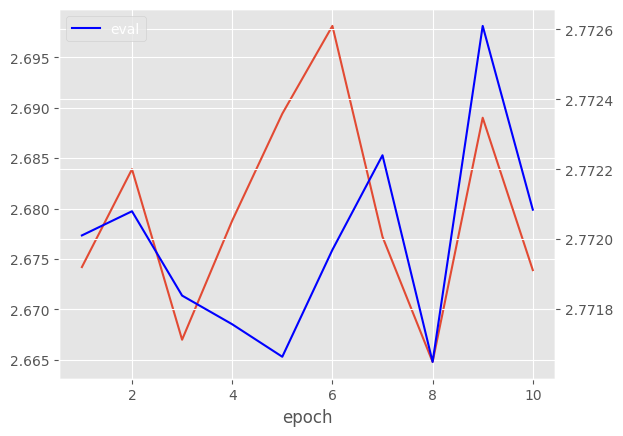

100%|██████████| 1/1 [00:00<00:00,  7.77it/s]


sokal hoax
{'before': 15.988316535949707, 'after': 15.98253059387207}


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.124, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 3.2923994064331055, 'eval_runtime': 0.1057, 'eval_samples_per_second': 9.456, 'eval_steps_per_second': 9.456, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.158, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 3.293436288833618, 'eval_runtime': 0.1029, 'eval_samples_per_second': 9.722, 'eval_steps_per_second': 9.722, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1423, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 3.292522668838501, 'eval_runtime': 0.0968, 'eval_samples_per_second': 10.336, 'eval_steps_per_second': 10.336, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1551, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 3.292370319366455, 'eval_runtime': 0.0978, 'eval_samples_per_second': 10.221, 'eval_steps_per_second': 10.221, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1887, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 3.2926437854766846, 'eval_runtime': 0.1006, 'eval_samples_per_second': 9.942, 'eval_steps_per_second': 9.942, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1303, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 3.2924861907958984, 'eval_runtime': 0.097, 'eval_samples_per_second': 10.309, 'eval_steps_per_second': 10.309, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1553, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 3.2921712398529053, 'eval_runtime': 0.098, 'eval_samples_per_second': 10.204, 'eval_steps_per_second': 10.204, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1617, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 3.2929515838623047, 'eval_runtime': 0.1014, 'eval_samples_per_second': 9.86, 'eval_steps_per_second': 9.86, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.177, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 3.2918519973754883, 'eval_runtime': 0.0963, 'eval_samples_per_second': 10.381, 'eval_steps_per_second': 10.381, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1702, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 3.292269229888916, 'eval_runtime': 0.097, 'eval_samples_per_second': 10.31, 'eval_steps_per_second': 10.31, 'epoch': 10.0}
{'train_runtime': 16.7488, 'train_samples_per_second': 1.194, 'train_steps_per_second': 0.597, 'train_loss': 3.1562697649002076, 'epoch': 10.0}


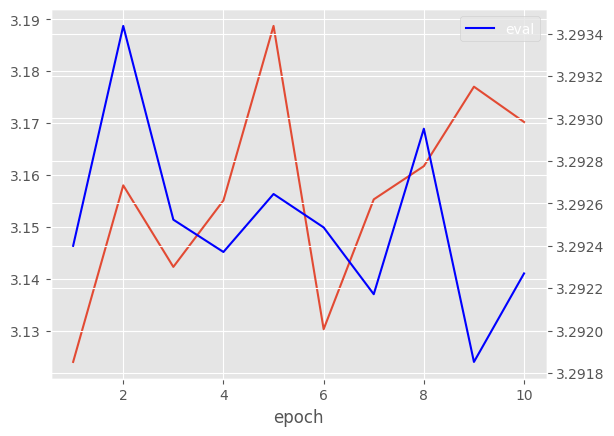

100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


Theory o. general relativity
{'before': 26.90251922607422, 'after': 26.887775421142578}


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 0.3854, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 0.4702971577644348, 'eval_runtime': 0.0685, 'eval_samples_per_second': 14.604, 'eval_steps_per_second': 14.604, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3339, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 0.4702734649181366, 'eval_runtime': 0.0704, 'eval_samples_per_second': 14.199, 'eval_steps_per_second': 14.199, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3039, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 0.47032833099365234, 'eval_runtime': 0.0711, 'eval_samples_per_second': 14.067, 'eval_steps_per_second': 14.067, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3085, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 0.4703848958015442, 'eval_runtime': 0.0708, 'eval_samples_per_second': 14.123, 'eval_steps_per_second': 14.123, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3198, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 0.47002241015434265, 'eval_runtime': 0.0714, 'eval_samples_per_second': 14.013, 'eval_steps_per_second': 14.013, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3547, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 0.4700290858745575, 'eval_runtime': 0.0693, 'eval_samples_per_second': 14.44, 'eval_steps_per_second': 14.44, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3611, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 0.47006598114967346, 'eval_runtime': 0.0705, 'eval_samples_per_second': 14.178, 'eval_steps_per_second': 14.178, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.328, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 0.47035178542137146, 'eval_runtime': 0.0721, 'eval_samples_per_second': 13.879, 'eval_steps_per_second': 13.879, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3103, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 0.47035568952560425, 'eval_runtime': 0.0711, 'eval_samples_per_second': 14.057, 'eval_steps_per_second': 14.057, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 0.3373, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 0.4699896275997162, 'eval_runtime': 0.0703, 'eval_samples_per_second': 14.228, 'eval_steps_per_second': 14.228, 'epoch': 10.0}
{'train_runtime': 12.8473, 'train_samples_per_second': 1.557, 'train_steps_per_second': 0.778, 'train_loss': 0.3342802584171295, 'epoch': 10.0}


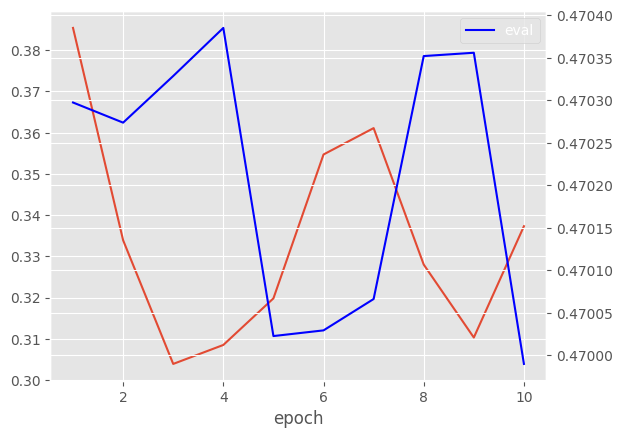

100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


lorem ipsum 
{'before': 1.600419521331787, 'after': 1.5999276638031006}


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.8088, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 3.472930669784546, 'eval_runtime': 0.0774, 'eval_samples_per_second': 12.92, 'eval_steps_per_second': 12.92, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8934, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 3.4726057052612305, 'eval_runtime': 0.0752, 'eval_samples_per_second': 13.289, 'eval_steps_per_second': 13.289, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8154, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 3.4735727310180664, 'eval_runtime': 0.0725, 'eval_samples_per_second': 13.796, 'eval_steps_per_second': 13.796, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8602, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 3.4736719131469727, 'eval_runtime': 0.0733, 'eval_samples_per_second': 13.636, 'eval_steps_per_second': 13.636, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8472, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 3.4726154804229736, 'eval_runtime': 0.0722, 'eval_samples_per_second': 13.86, 'eval_steps_per_second': 13.86, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8786, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 3.473383903503418, 'eval_runtime': 0.0734, 'eval_samples_per_second': 13.632, 'eval_steps_per_second': 13.632, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8225, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 3.472898244857788, 'eval_runtime': 0.0725, 'eval_samples_per_second': 13.797, 'eval_steps_per_second': 13.797, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.83, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 3.4716172218322754, 'eval_runtime': 0.0731, 'eval_samples_per_second': 13.686, 'eval_steps_per_second': 13.686, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8249, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 3.4717400074005127, 'eval_runtime': 0.0736, 'eval_samples_per_second': 13.586, 'eval_steps_per_second': 13.586, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.8463, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 3.4718592166900635, 'eval_runtime': 0.0736, 'eval_samples_per_second': 13.585, 'eval_steps_per_second': 13.585, 'epoch': 10.0}
{'train_runtime': 14.973, 'train_samples_per_second': 1.336, 'train_steps_per_second': 0.668, 'train_loss': 2.842736101150513, 'epoch': 10.0}


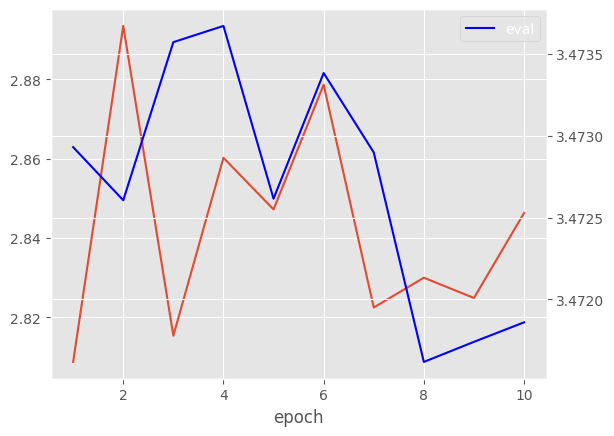

100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


wikipedia on LK-99
{'before': 32.226192474365234, 'after': 32.18389892578125}


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 1.4629, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 0.7537348866462708, 'eval_runtime': 0.0738, 'eval_samples_per_second': 13.551, 'eval_steps_per_second': 13.551, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.5278, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 0.7536290884017944, 'eval_runtime': 0.0735, 'eval_samples_per_second': 13.603, 'eval_steps_per_second': 13.603, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.5075, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 0.7543337941169739, 'eval_runtime': 0.0709, 'eval_samples_per_second': 14.104, 'eval_steps_per_second': 14.104, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.432, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 0.7537673711776733, 'eval_runtime': 0.0738, 'eval_samples_per_second': 13.55, 'eval_steps_per_second': 13.55, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.4949, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 0.7528185248374939, 'eval_runtime': 0.0731, 'eval_samples_per_second': 13.679, 'eval_steps_per_second': 13.679, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.5574, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 0.7516946792602539, 'eval_runtime': 0.0717, 'eval_samples_per_second': 13.952, 'eval_steps_per_second': 13.952, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.5096, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 0.7530063986778259, 'eval_runtime': 0.073, 'eval_samples_per_second': 13.702, 'eval_steps_per_second': 13.702, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.4305, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 0.75247722864151, 'eval_runtime': 0.0714, 'eval_samples_per_second': 14.0, 'eval_steps_per_second': 14.0, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.4682, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 0.7539510726928711, 'eval_runtime': 0.0726, 'eval_samples_per_second': 13.777, 'eval_steps_per_second': 13.777, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 1.4889, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 0.752701461315155, 'eval_runtime': 0.0737, 'eval_samples_per_second': 13.57, 'eval_steps_per_second': 13.57, 'epoch': 10.0}
{'train_runtime': 12.2685, 'train_samples_per_second': 1.63, 'train_steps_per_second': 0.815, 'train_loss': 1.4879708528518676, 'epoch': 10.0}


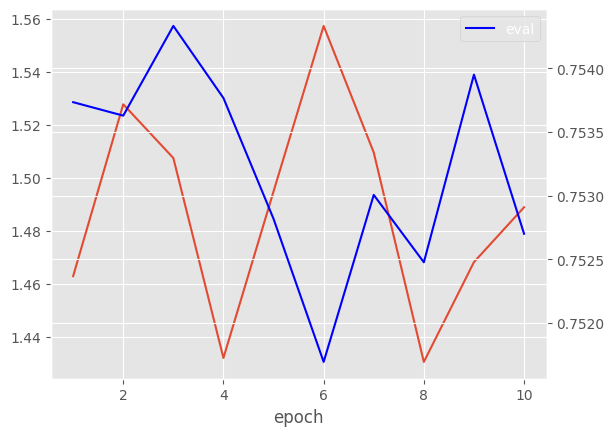

100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


I have a dream
{'before': 2.124803304672241, 'after': 2.120471954345703}


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.3804, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 2.0329105854034424, 'eval_runtime': 0.1215, 'eval_samples_per_second': 8.234, 'eval_steps_per_second': 8.234, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.3772, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 2.03286075592041, 'eval_runtime': 0.1219, 'eval_samples_per_second': 8.202, 'eval_steps_per_second': 8.202, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.3615, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 2.0326783657073975, 'eval_runtime': 0.1217, 'eval_samples_per_second': 8.215, 'eval_steps_per_second': 8.215, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.369, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 2.0326778888702393, 'eval_runtime': 0.1212, 'eval_samples_per_second': 8.254, 'eval_steps_per_second': 8.254, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.3635, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 2.0327913761138916, 'eval_runtime': 0.1215, 'eval_samples_per_second': 8.232, 'eval_steps_per_second': 8.232, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.341, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 2.032545328140259, 'eval_runtime': 0.1205, 'eval_samples_per_second': 8.301, 'eval_steps_per_second': 8.301, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.384, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 2.0328757762908936, 'eval_runtime': 0.1194, 'eval_samples_per_second': 8.376, 'eval_steps_per_second': 8.376, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.3573, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 2.0324862003326416, 'eval_runtime': 0.1222, 'eval_samples_per_second': 8.185, 'eval_steps_per_second': 8.185, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.3939, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 2.032426595687866, 'eval_runtime': 0.12, 'eval_samples_per_second': 8.334, 'eval_steps_per_second': 8.334, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.365, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 2.0326268672943115, 'eval_runtime': 0.1265, 'eval_samples_per_second': 7.902, 'eval_steps_per_second': 7.902, 'epoch': 10.0}
{'train_runtime': 13.9125, 'train_samples_per_second': 1.438, 'train_steps_per_second': 0.719, 'train_loss': 2.3692641973495485, 'epoch': 10.0}


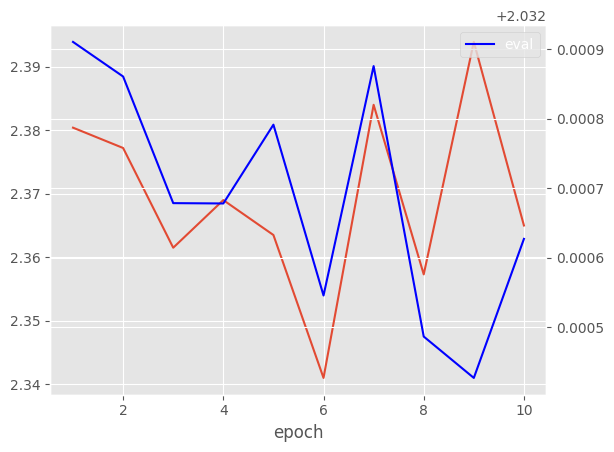

100%|██████████| 1/1 [00:00<00:00,  8.13it/s]


AI gen fake paper
{'before': 7.635533809661865, 'after': 7.631838798522949}


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.4767, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 3.388134241104126, 'eval_runtime': 0.1253, 'eval_samples_per_second': 7.981, 'eval_steps_per_second': 7.981, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4838, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 3.3873133659362793, 'eval_runtime': 0.1259, 'eval_samples_per_second': 7.945, 'eval_steps_per_second': 7.945, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4723, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 3.387073278427124, 'eval_runtime': 0.1267, 'eval_samples_per_second': 7.893, 'eval_steps_per_second': 7.893, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.5019, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 3.387176513671875, 'eval_runtime': 0.125, 'eval_samples_per_second': 8.003, 'eval_steps_per_second': 8.003, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4934, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 3.387197256088257, 'eval_runtime': 0.1234, 'eval_samples_per_second': 8.102, 'eval_steps_per_second': 8.102, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.5131, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 3.3876898288726807, 'eval_runtime': 0.126, 'eval_samples_per_second': 7.938, 'eval_steps_per_second': 7.938, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4993, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 3.3870561122894287, 'eval_runtime': 0.1262, 'eval_samples_per_second': 7.927, 'eval_steps_per_second': 7.927, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4632, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 3.3876845836639404, 'eval_runtime': 0.1357, 'eval_samples_per_second': 7.372, 'eval_steps_per_second': 7.372, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.5131, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 3.3870444297790527, 'eval_runtime': 0.1251, 'eval_samples_per_second': 7.992, 'eval_steps_per_second': 7.992, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.4708, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 3.387460708618164, 'eval_runtime': 0.125, 'eval_samples_per_second': 7.998, 'eval_steps_per_second': 7.998, 'epoch': 10.0}
{'train_runtime': 15.2221, 'train_samples_per_second': 1.314, 'train_steps_per_second': 0.657, 'train_loss': 3.488762640953064, 'epoch': 10.0}


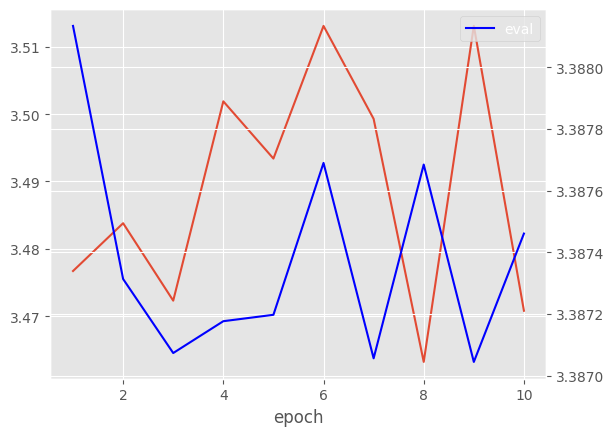

100%|██████████| 1/1 [00:00<00:00,  8.40it/s]


Schmidhuber 2023 Subjective Novelty, Surprise
{'before': 29.606185913085938, 'after': 29.573911666870117}


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.2565, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 3.2224748134613037, 'eval_runtime': 0.1146, 'eval_samples_per_second': 8.723, 'eval_steps_per_second': 8.723, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2123, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 3.2232015132904053, 'eval_runtime': 0.1158, 'eval_samples_per_second': 8.633, 'eval_steps_per_second': 8.633, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1825, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 3.223541736602783, 'eval_runtime': 0.1154, 'eval_samples_per_second': 8.666, 'eval_steps_per_second': 8.666, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2017, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 3.2232275009155273, 'eval_runtime': 0.1157, 'eval_samples_per_second': 8.641, 'eval_steps_per_second': 8.641, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2476, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 3.2222542762756348, 'eval_runtime': 0.1131, 'eval_samples_per_second': 8.84, 'eval_steps_per_second': 8.84, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2973, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 3.2214126586914062, 'eval_runtime': 0.1191, 'eval_samples_per_second': 8.395, 'eval_steps_per_second': 8.395, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.1922, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 3.22304630279541, 'eval_runtime': 0.1168, 'eval_samples_per_second': 8.56, 'eval_steps_per_second': 8.56, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2295, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 3.2223405838012695, 'eval_runtime': 0.1154, 'eval_samples_per_second': 8.668, 'eval_steps_per_second': 8.668, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2669, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 3.22277569770813, 'eval_runtime': 0.1219, 'eval_samples_per_second': 8.205, 'eval_steps_per_second': 8.205, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.2785, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 3.22255539894104, 'eval_runtime': 0.1181, 'eval_samples_per_second': 8.466, 'eval_steps_per_second': 8.466, 'epoch': 10.0}
{'train_runtime': 13.6454, 'train_samples_per_second': 1.466, 'train_steps_per_second': 0.733, 'train_loss': 3.2364880084991454, 'epoch': 10.0}


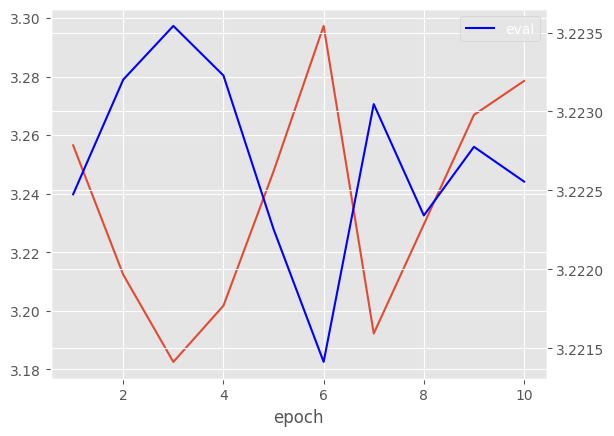

100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


email_to_fauci
{'before': 25.085100173950195, 'after': 25.0584774017334}


100%|██████████| 1/1 [00:00<00:00, 26.31it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 3.6233, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 3.24851131439209, 'eval_runtime': 0.0612, 'eval_samples_per_second': 16.329, 'eval_steps_per_second': 16.329, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.8175, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 3.24828839302063, 'eval_runtime': 0.0618, 'eval_samples_per_second': 16.173, 'eval_steps_per_second': 16.173, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.6368, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 3.247272491455078, 'eval_runtime': 0.0625, 'eval_samples_per_second': 16.012, 'eval_steps_per_second': 16.012, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.7074, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 3.2483201026916504, 'eval_runtime': 0.0634, 'eval_samples_per_second': 15.772, 'eval_steps_per_second': 15.772, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.5788, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 3.247889280319214, 'eval_runtime': 0.0619, 'eval_samples_per_second': 16.157, 'eval_steps_per_second': 16.157, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.7083, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 3.2475459575653076, 'eval_runtime': 0.0633, 'eval_samples_per_second': 15.8, 'eval_steps_per_second': 15.8, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.6332, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 3.247795820236206, 'eval_runtime': 0.0629, 'eval_samples_per_second': 15.892, 'eval_steps_per_second': 15.892, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.6081, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 3.2480216026306152, 'eval_runtime': 0.1059, 'eval_samples_per_second': 9.444, 'eval_steps_per_second': 9.444, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.691, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 3.2482614517211914, 'eval_runtime': 0.0617, 'eval_samples_per_second': 16.214, 'eval_steps_per_second': 16.214, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 3.667, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 3.247227191925049, 'eval_runtime': 0.0614, 'eval_samples_per_second': 16.286, 'eval_steps_per_second': 16.286, 'epoch': 10.0}
{'train_runtime': 12.2797, 'train_samples_per_second': 1.629, 'train_steps_per_second': 0.814, 'train_loss': 3.6671237468719484, 'epoch': 10.0}


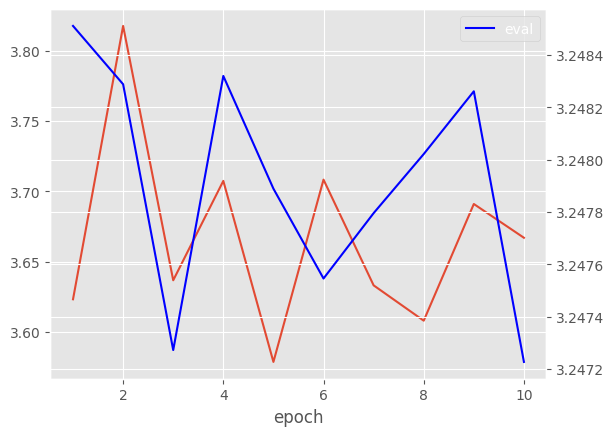

100%|██████████| 1/1 [00:00<00:00, 29.60it/s]


enron_email1
{'before': 25.75173568725586, 'after': 25.71868133544922}


100%|██████████| 1/1 [00:00<00:00, 11.35it/s]
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'loss': 2.1729, 'learning_rate': 2.5e-06, 'epoch': 1.0}
{'eval_loss': 2.7643606662750244, 'eval_runtime': 0.0794, 'eval_samples_per_second': 12.601, 'eval_steps_per_second': 12.601, 'epoch': 1.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.2248, 'learning_rate': 5e-06, 'epoch': 2.0}
{'eval_loss': 2.764103651046753, 'eval_runtime': 0.0754, 'eval_samples_per_second': 13.266, 'eval_steps_per_second': 13.266, 'epoch': 2.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.2077, 'learning_rate': 7.500000000000001e-06, 'epoch': 3.0}
{'eval_loss': 2.7643258571624756, 'eval_runtime': 0.0762, 'eval_samples_per_second': 13.132, 'eval_steps_per_second': 13.132, 'epoch': 3.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.1904, 'learning_rate': 1e-05, 'epoch': 4.0}
{'eval_loss': 2.764200210571289, 'eval_runtime': 0.0762, 'eval_samples_per_second': 13.12, 'eval_steps_per_second': 13.12, 'epoch': 4.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.1783, 'learning_rate': 8.333333333333334e-06, 'epoch': 5.0}
{'eval_loss': 2.764207363128662, 'eval_runtime': 0.0824, 'eval_samples_per_second': 12.139, 'eval_steps_per_second': 12.139, 'epoch': 5.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.1669, 'learning_rate': 6.666666666666667e-06, 'epoch': 6.0}
{'eval_loss': 2.7637062072753906, 'eval_runtime': 0.0775, 'eval_samples_per_second': 12.896, 'eval_steps_per_second': 12.896, 'epoch': 6.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.2314, 'learning_rate': 5e-06, 'epoch': 7.0}
{'eval_loss': 2.763810396194458, 'eval_runtime': 0.0755, 'eval_samples_per_second': 13.249, 'eval_steps_per_second': 13.249, 'epoch': 7.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.2212, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.0}
{'eval_loss': 2.7638185024261475, 'eval_runtime': 0.0757, 'eval_samples_per_second': 13.212, 'eval_steps_per_second': 13.212, 'epoch': 8.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.2015, 'learning_rate': 1.6666666666666667e-06, 'epoch': 9.0}
{'eval_loss': 2.76403546333313, 'eval_runtime': 0.0768, 'eval_samples_per_second': 13.022, 'eval_steps_per_second': 13.022, 'epoch': 9.0}


/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


{'loss': 2.2409, 'learning_rate': 0.0, 'epoch': 10.0}
{'eval_loss': 2.763981342315674, 'eval_runtime': 0.0766, 'eval_samples_per_second': 13.047, 'eval_steps_per_second': 13.047, 'epoch': 10.0}
{'train_runtime': 12.2564, 'train_samples_per_second': 1.632, 'train_steps_per_second': 0.816, 'train_loss': 2.2035992622375487, 'epoch': 10.0}


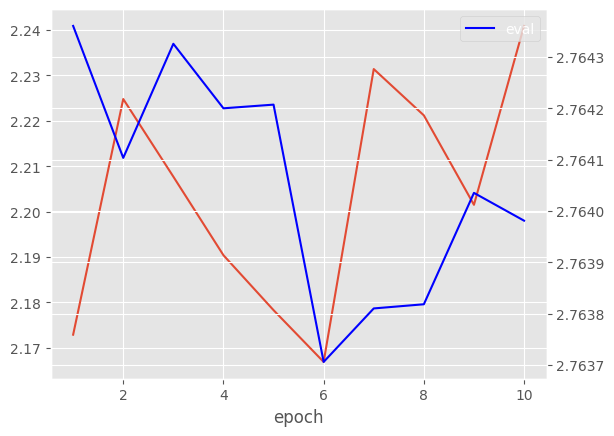

100%|██████████| 1/1 [00:00<00:00, 11.59it/s]

openai_board_ann
{'before': 15.866617202758789, 'after': 15.856237411499023}


In [15]:
data = []
for sample in samples:
    r = learn_sample(sample)
    print(sample['name'])
    print(dict(before=r['before'], after=r['after']))
    data.append(dict(**r, **sample))

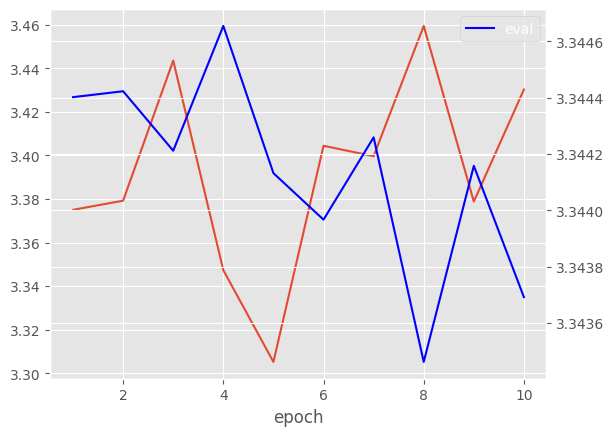

In [16]:
df_hist = data[1]['hist']#.groupby('epoch').last().dropna(axis=1).drop(columns=['step'])
df_hist['loss'].plot(label='train')
plt.twinx()
df_hist['eval_loss'].plot(c='b', label='eval')
plt.legend()
plt.show()


### Perplexity

Perplexity measures how well a language model predicts a text sample. Lower is better

It’s calculated as the average number of bits per word a model needs to represent the same

https://huggingface.co/docs/transformers/perplexity
https://thegradient.pub/understanding-evaluation-metrics-for-language-models/

The **improvement** column, is perplexity decrease

In [17]:
df_res = pd.DataFrame(data)
df_res['len'] = df_res.text.str.len()
df_res = df_res[['before', 'after', 'name', 'in_training', 'len']].set_index('name')
df_res['improvement%'] = (df_res['before'] - df_res['after'])/ df_res['before']
df_res['improvement'] = (df_res['before'] - df_res['after'])
df_res.sort_values('improvement%', ascending=False)

,before,after,in_training,len,improvement%,improvement
name,,,,,,
I have a dream,2.124803,2.120472,True,848,0.002038,0.004331
wikipedia on LK-99,32.226192,32.183899,False,1038,0.001312,0.042294
enron_email1,25.751736,25.718681,True,445,0.001284,0.033054
"Schmidhuber 2023 Subjective Novelty, Surprise",29.606186,29.573912,False,2654,0.001090,0.032274
email_to_fauci,25.085100,25.058477,False,1559,0.001061,0.026623
good_ml,28.339096,28.312433,False,1004,0.000941,0.026663
bad_ml,13.885271,13.874103,False,2345,0.000804,0.011168
openai_board_ann,15.866617,15.856237,False,1191,0.000654,0.010380
Theory o. general relativity,26.902519,26.887775,True,1378,0.000548,0.014744


# DEBUG

In [18]:
from IPython.display import display, HTML, Markdown
import torch

@torch.no_grad()
def gen(model, inputs, tokenizer, clean=True):
    s = model.generate(
        input_ids=inputs["input_ids"][None, :].to(model.device),
        attention_mask=inputs["attention_mask"][None, :].to(model.device),
        use_cache=False,
        max_new_tokens=100,
        min_new_tokens=100,
        do_sample=False,
        early_stopping=False,
    )
    input_l = inputs["input_ids"].shape[0]
    tokenizer_kwargs=dict(clean_up_tokenization_spaces=clean, skip_special_tokens=clean)
    old = tokenizer.decode(
        s[0, :input_l], **tokenizer_kwargs
    )
    new = tokenizer.decode(
        s[0, input_l:], **tokenizer_kwargs
    )
    s_old = ""+old.replace('\n', '<br>')
    s_new =  '<b>' + new.replace('\n', '<br>')+ '<br><br><b/>'
    display(HTML(f"{s_old}{s_new}"))
    # print([old, new])



In [19]:
sample = samples[1]
s = sample['text']
first_half = s[:len(s)//2]
second_half = s[len(s)//2:]
ds_train = Dataset.from_dict(tokenizer([first_half]))
ds_val = Dataset.from_dict(tokenizer([second_half]))

In [20]:
with model.disable_adapter():
    gen(model, ds_train.with_format('pt')[0], tokenizer)

/media/wassname/SGIronWolf/projects5/bs_writing_detector/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [21]:
gen(model, ds_train.with_format('pt')[0], tokenizer)